In [1]:
from google.colab import drive
drive = drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/Deeplearning_pytorch_Textbook/chap05

/content/drive/MyDrive/Colab Notebooks/Deeplearning_pytorch_Textbook/chap05


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [5]:
# 하나의 gpu를 이용하는 경우

"""
model = Net()
model.to(device)
"""

'\nmodel = Net()\nmodel.to(device)\n'

In [6]:
# 여러개 gpu 사용
"""
if torch.cuda.device_count() > 1:
  model = nn.DataParallel(net) #nn. Pararrel로 할당. -> batch 자동 할당이므로 batch 크기 늘려줘야.
model.to(device)"""

'\nif torch.cuda.device_count() > 1:\n  model = nn.DataParallel(net) #nn. Pararrel로 할당. -> batch 자동 할당이므로 batch 크기 늘려줘야.\nmodel.to(device)'

In [7]:
train_dataset = torchvision.datasets.FashionMNIST('/data',download = True, transform = transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST('/data',download = True, train = False, transform = transforms.Compose([transforms.ToTensor()]))


In [8]:
train_loader = DataLoader(train_dataset, batch_size = 100)
test_loader = DataLoader(test_dataset, batch_size = 100)

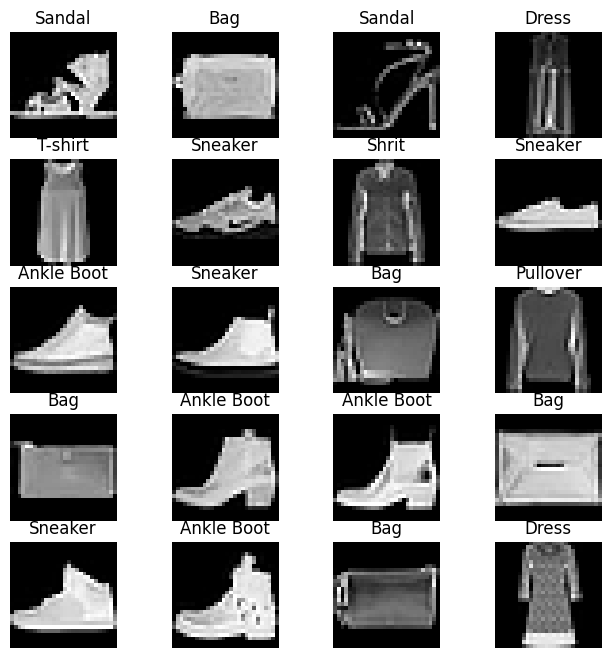

In [9]:
labels_map = {0: 'T-shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6 : 'Shrit', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'}

fig = plt.figure(figsize=(8,8))
columns = 4
rows = 5
for i in range(1, columns*rows+1):
  img_xy = np.random.randint(len(train_dataset))
  img = train_dataset[img_xy][0][0,:,:]
  fig.add_subplot(rows, columns, i)
  plt.title(labels_map[train_dataset[img_xy][1]])
  plt.axis('off')
  plt.imshow(img,cmap='gray')
plt.show()

Dropout(0.2)를 한다고 가정

노드가 0.2의 확률로 정보 날아감.

남은 노드는 다시 비율을 맞춰주기 위해 1/0.8만큼 커진다.

In [10]:
class FashionDNN(nn.Module):
  def __init__(self):
    super(FashionDNN, self).__init__()
    self.fc1 = nn.Linear(in_features = 784, out_features = 256)
    self.drop = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features = 256, out_features = 128)
    self.fc3 = nn.Linear(in_features = 128, out_features = 10)

  def forward(self, input_data):
    out = input_data.view(-1, 784) #2차원 tensor로 변경하기 위해서 이거사용함. 1차원인 경우 flatten()
    out = F.relu(self.fc1(out))
    out = self.drop(out)
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out


a = torch.tensor([[1,2],[3,4]])
print(a.flatten()) #1차원 텐서가됨
print(a.view(-1,4)) #2차원 텐서가됨

tensor([1, 2, 3, 4])
tensor([[1, 2, 3, 4]])


In [11]:
learning_rate = 1e-3
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [12]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)
    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count%50):
      total = 0
      correct = 0
      for images, labels, in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100,1,28,28))
        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct*100/total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)
    if not (count%500):
      print("Iteration: {}, Loss : {}, Accuracy: {}%".format(count, loss.data, accuracy))







Iteration: 500, Loss : 0.5623274445533752, Accuracy: 83.93999481201172%
Iteration: 1000, Loss : 0.4594685435295105, Accuracy: 84.54000091552734%
Iteration: 1500, Loss : 0.3962821066379547, Accuracy: 84.38999938964844%
Iteration: 2000, Loss : 0.3716448247432709, Accuracy: 85.32999420166016%
Iteration: 2500, Loss : 0.2352401316165924, Accuracy: 86.18000030517578%
Iteration: 3000, Loss : 0.2606232166290283, Accuracy: 86.87999725341797%


In [13]:
class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc1 = nn.Linear(in_features = 64*6*6, out_features = 600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(in_features = 600, out_features = 120)
    self.fc3 = nn.Linear(in_features = 120, out_features = 10)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    x = self.drop(x)
    x = self.fc2(x)
    x = self.fc3(x)
    return x

In [14]:
#convolution layer 마다 w, h, c 계산
img  = train_loader.__iter__().__next__()[0]
print(img.shape) #1 x 28 x 28
#conv2d outchannels = 32, kernel size 3 padding 1
#-> 32 x 28 x 28
""" max pool -> 32 x 14 x 14
conv2d -> 64, 13 x 13
maxpool -> 64, 6 x 6"""



torch.Size([100, 1, 28, 28])


' max pool -> 32 x 14 x 14\nconv2d -> 64, 13 x 13\nmaxpool -> 64, 6 x 6'

In [15]:
learning_rate = 0.01
model = FashionCNN()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [16]:
num_epoch = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epoch):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100,1,28,28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count%50):
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100,1,28,28))
        labels = Variable(labels)
        outputs = model(test)
        predictions = torch.max(outputs,1)[1].to(device) #예측값이 가장 큰 것을 해당 class로 할당
        predictions_list.append(predictions)
        correct += (predictions==labels).sum()
        total += len(labels)
      accuracy = correct*100/total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count%500):
      print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.5736382007598877, Accuracy: 84.31999969482422%
Iteration: 1000, Loss: 0.37976160645484924, Accuracy: 87.12999725341797%
Iteration: 1500, Loss: 0.3459109365940094, Accuracy: 86.5%
Iteration: 2000, Loss: 0.30602312088012695, Accuracy: 88.66999816894531%
Iteration: 2500, Loss: 0.17725877463817596, Accuracy: 89.02999877929688%
Iteration: 3000, Loss: 0.2703225314617157, Accuracy: 86.73999786376953%


## Transfer Learning

In [17]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [19]:
data_path = './data/catanddog/train'

transform = transforms.Compose([
        transforms.Resize([256,256]),#이미지 사이즈 조정
        transforms.RandomResizedCrop(224),# 랜덤한크기 및 비율로 자름 -> Augmentation
        transforms.RandomHorizontalFlip(), # 수평기준으로 flipping
        transforms.ToTensor() #이미지 데이터를 텐서로 변환
    ])
train_dataset = torchvision.datasets.ImageFolder( #데이터로더가 데이터를 불러올 경로와 transform을 정의
    data_path,
    transform = transform
)
#image folder로 가져오면 라벨이 폴더명이 되는건가? -> 맞는 것으로 확인됨.
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 32,
    num_workers = 2,
    shuffle = True
)

print(len(train_dataset))

385


### RandomResizedCrop 살펴보기

In [20]:
!pip install mxnet
!pip install --user mxnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


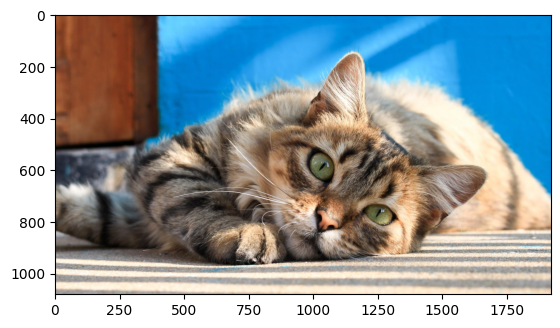

In [21]:
import mxnet as mx
from mxnet.gluon.data.vision import transforms

example_image = mx.image.imread('./data/cat.jpg')
plt.imshow(example_image.asnumpy()) #넘파이 행렬로 변환 후 출력

In [22]:
def show_images(imgs, num_rows, num_cols, scale = 2):
  aspect_ratio = imgs[0].shape[0]/img[0].shape[1]
  figsize = (num_cols * scale, num_rows * scale * aspect_ratio)
  _, axes = plt.subplots(num_rows, num_cols, figsize = figsize)
  for i in range(num_rows):
    for j in range(num_cols):
      axes[i][j].imshow(imgs[i*num_cols + j].asnumpy())
      axes[i][j].axes.get_xaxis().set_visible(False)
      axes[i][j].axes.get_yaxis().set_visible(False)
  plt.subplots_adjust(hspace = 0.1, wspace = 0)
  return axes

def apply(img, aug, num_rows = 2, num_cols = 4, scale= 3):
  Y = [aug(img) for _ in range(num_rows * num_cols)]
  show_images(Y, num_rows, num_cols, scale)


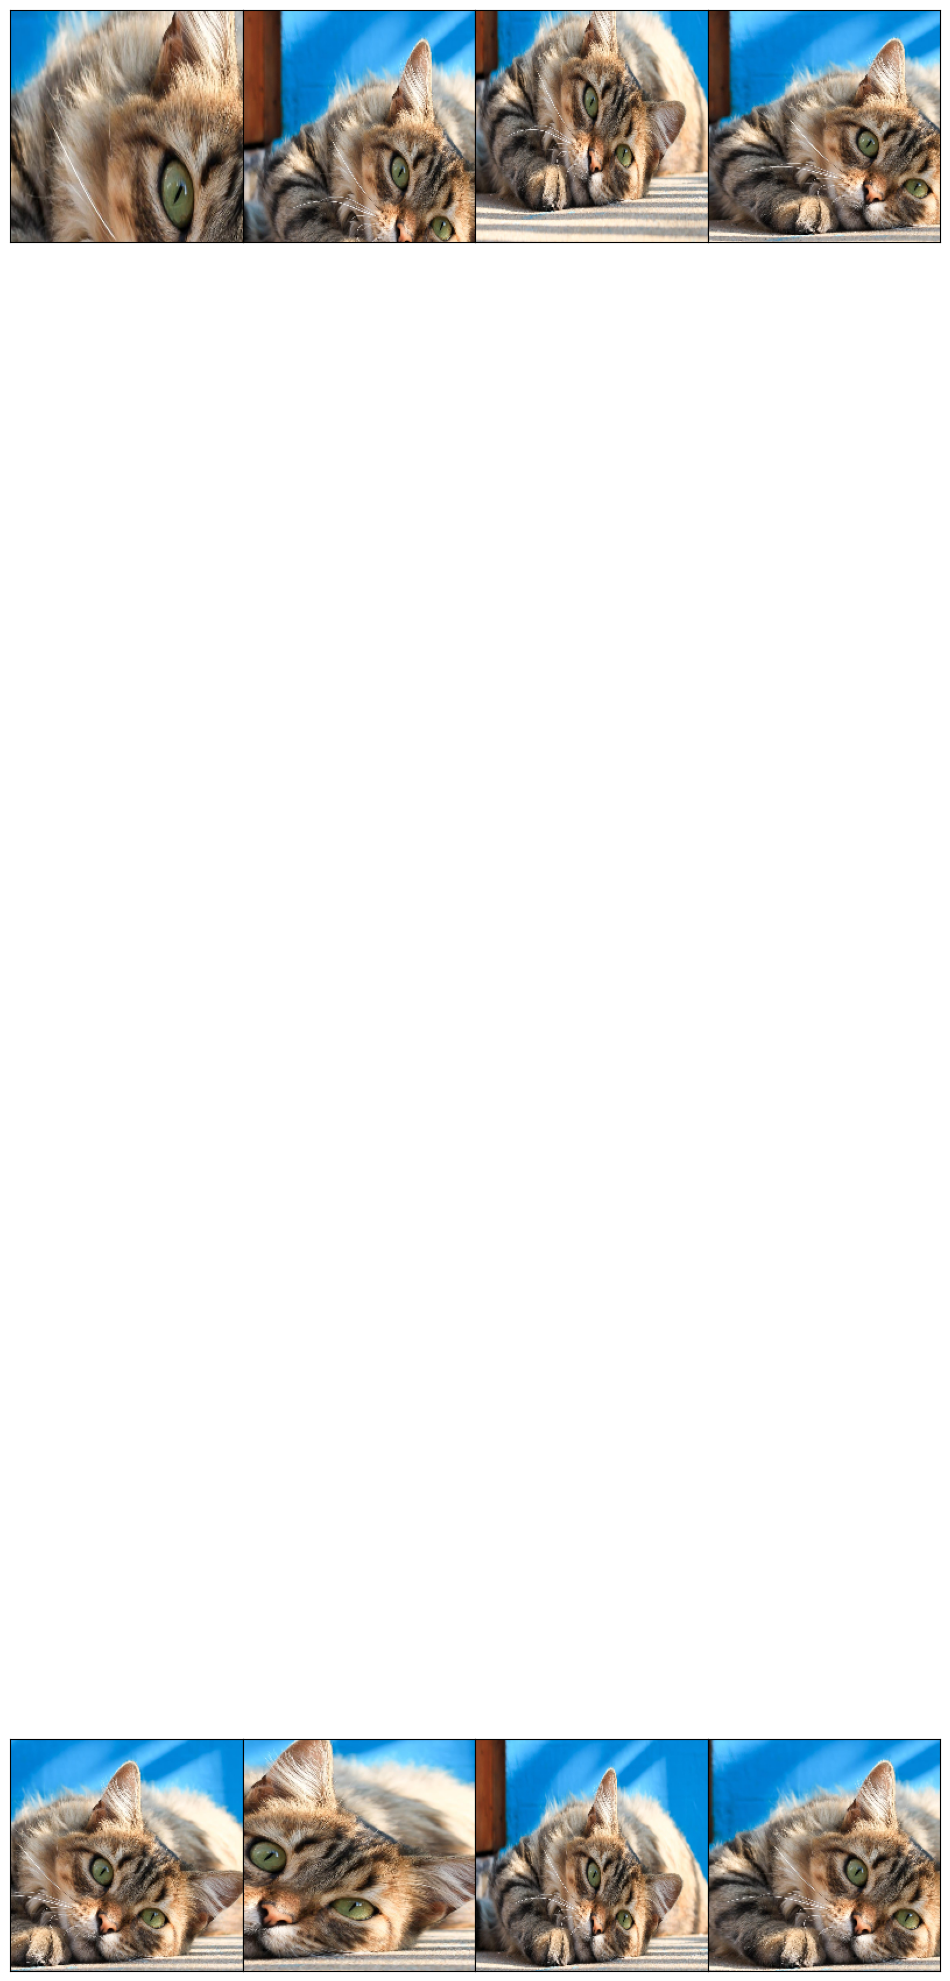

In [23]:
shape_aug = transforms.RandomResizedCrop(size = (200,200), #사이즈 맞추기
                                         scale = (0.1, 1), #면적 비율 0.1 ~ 1로 자름
                                         ratio = (0.5, 2)) #면적의 너비와 높이 비율 0.5~2로 무작위 조절
                                         #비율 조절 후 scale로 자르고 size로 최종 이미지 크기 조정
apply(example_image, shape_aug)

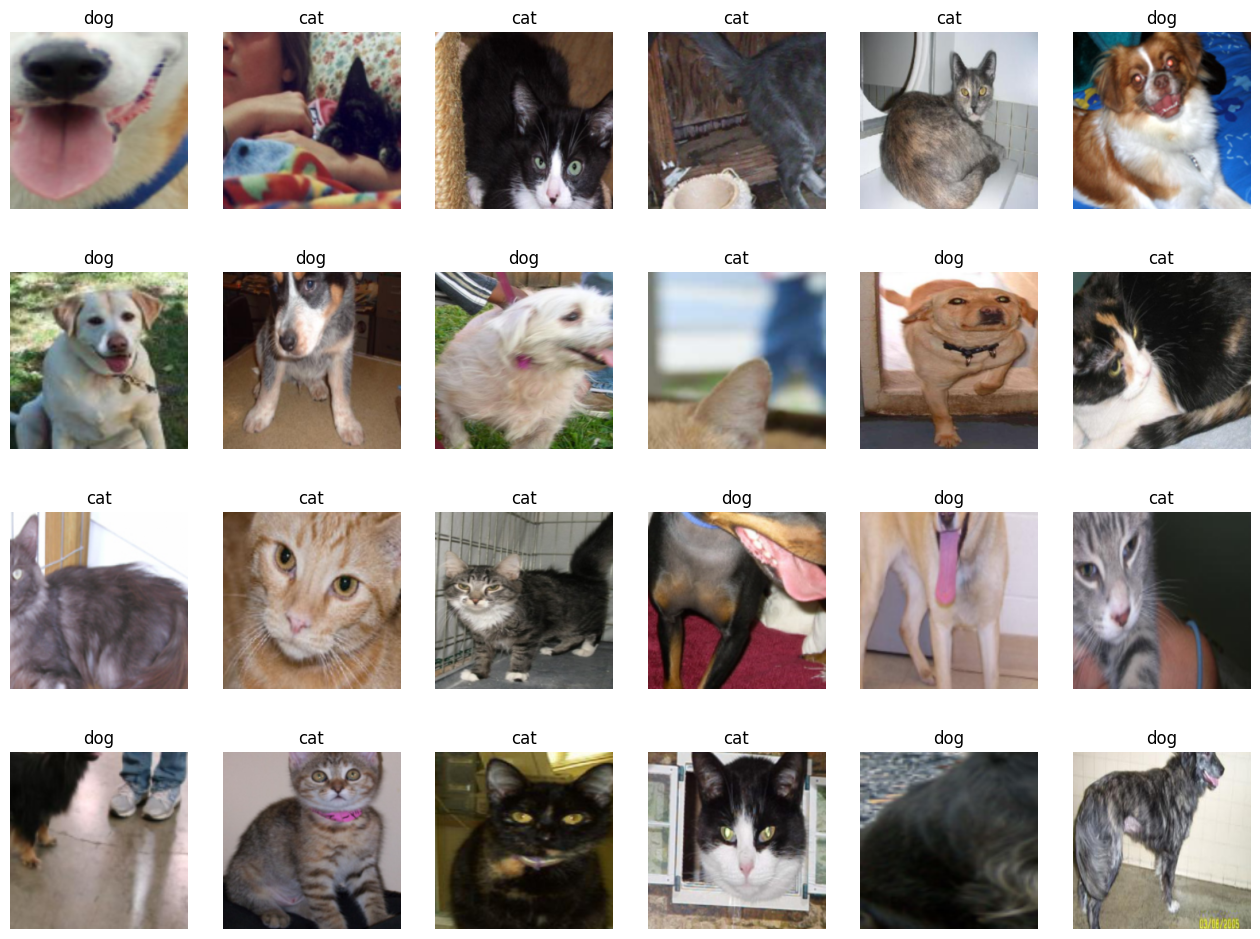

In [24]:
samples, labels = train_loader.__iter__().__next__() #batchsize 32개만큼의 데이터가 나옴.
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize = (16,24))
for i in range(24): #24개까지만
  a = fig.add_subplot(4,6,i+1) #4 x 6사이즈의 i번째 칸에
  a.set_title(classes[labels[i].item()]) #item네임으로 이름을 달고
  a.axis('off') #축 날리고
  a.imshow(np.transpose(samples[i].numpy(), (1,2,0))) #imshow와 맞게끔 3 224 224 -> 224 224 3 으로 변경
plt.subplots_adjust(bottom = 0.2, top = 0.6, hspace = 0) #사이 간격조정

In [25]:
#np.transpose practice

temp_np = np.arange(24).reshape(3,2,4)
print(temp_np.shape)
temp_np #3,2,4 shape

(3, 2, 4)


array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7]],

       [[ 8,  9, 10, 11],
        [12, 13, 14, 15]],

       [[16, 17, 18, 19],
        [20, 21, 22, 23]]])

In [26]:
temp_np = np.transpose(temp_np, (1,0,2)) #2,3,4 shape
print(temp_np.shape)
temp_np

(2, 3, 4)


array([[[ 0,  1,  2,  3],
        [ 8,  9, 10, 11],
        [16, 17, 18, 19]],

       [[ 4,  5,  6,  7],
        [12, 13, 14, 15],
        [20, 21, 22, 23]]])

### Resnet

In [27]:
resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
#파라미터 고정
def set_harameter_requires_grad(model, feature_extracting=True):
  if feature_extracting:
    for param in model.parameters(): #모델 하이퍼파라미터에
      param.requires_grad = False #개별적으로 gradient계산 막음.

In [29]:
resnet18.fc = nn.Linear(512,2) # fclayer 하나 추가

In [30]:
for name, param in resnet18.named_parameters():
  if param.requires_grad:
    print(name, param.data)

conv1.weight tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
            3.6887e-01,  1.2455e-01],
       

In [31]:
model = models.resnet18(pretrained = True) #모델 불러오기

for param in model.parameters():
  param.requires_grad = False #covolution 층 가중치 고정

model.fc = torch.nn.Linear(512,2) #레이어 추가
for param in model.fc.parameters():
  param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
#train fucntion

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs = 13, is_train = True):
  since = time.time()
  acc_history = []
  loss_history = []
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print("-"*10)

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels, in dataloaders:
      inputs = inputs.to(device)
      labels = labels.to(device)

      model.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = cost(outputs, labels)
      _, preds = torch.max(outputs, 1)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()*inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloaders.dataset)
    epoch_acc = running_corrects.double() / len(dataloaders.dataset)

    print('Loss: {:.4f} ACC: {:,.4f}'.format(epoch_loss, epoch_acc))

    if epoch_acc > best_acc:
      best_acc = epoch_acc

    acc_history.append(epoch_acc.item())
    loss_history.append(epoch_loss)
    torch.save(model.state_dict(), os.path.join('./data/catanddog/', '{0:0=2d}.pth'.format(epoch)))
    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best Acc: {:4f}'.format(best_acc))
  return acc_history, loss_history

In [33]:
params_to_update = []
for name, param in resnet18.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)
    print("\t", name)
optimizer = optim.Adam(params_to_update)

	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.bn2.weight
	 layer

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.6724 ACC: 0.7403

Epoch 1/12
----------
Loss: 0.5814 ACC: 0.7143

Epoch 2/12
----------
Loss: 0.4846 ACC: 0.7403

Epoch 3/12
----------
Loss: 0.4090 ACC: 0.7792

Epoch 4/12
----------
Loss: 0.3652 ACC: 0.8182

Epoch 5/12
----------
Loss: 0.3718 ACC: 0.8312

Epoch 6/12
----------
Loss: 0.3287 ACC: 0.8442

Epoch 7/12
----------
Loss: 0.3586 ACC: 0.8442

Epoch 8/12
----------
Loss: 0.2923 ACC: 0.8701

Epoch 9/12
----------
Loss: 0.2851 ACC: 0.8649

Epoch 10/12
----------
Loss: 0.2665 ACC: 0.8883

Epoch 11/12
----------
Loss: 0.3468 ACC: 0.8364

Epoch 12/12
----------
Loss: 0.3091 ACC: 0.8649

Training complete in 0m 59s
Best Acc: 0.888312


In [35]:
test_path = './data/catanddog/test'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),#augmentation 필요 없으므로 centercrop만
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))


98


In [36]:
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('../chap05/data/catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels.cpu()).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history

In [37]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['../chap05/data/catanddog/00.pth', '../chap05/data/catanddog/01.pth', '../chap05/data/catanddog/02.pth', '../chap05/data/catanddog/03.pth', '../chap05/data/catanddog/04.pth', '../chap05/data/catanddog/05.pth', '../chap05/data/catanddog/06.pth', '../chap05/data/catanddog/07.pth', '../chap05/data/catanddog/08.pth', '../chap05/data/catanddog/09.pth', '../chap05/data/catanddog/10.pth', '../chap05/data/catanddog/11.pth', '../chap05/data/catanddog/12.pth']
Loading model ../chap05/data/catanddog/00.pth


ValueError: ignored

## 오류로 인해 다시 실행

In [38]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [39]:
data_path = '../chap05/data/catanddog/train'

transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ])
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

385


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


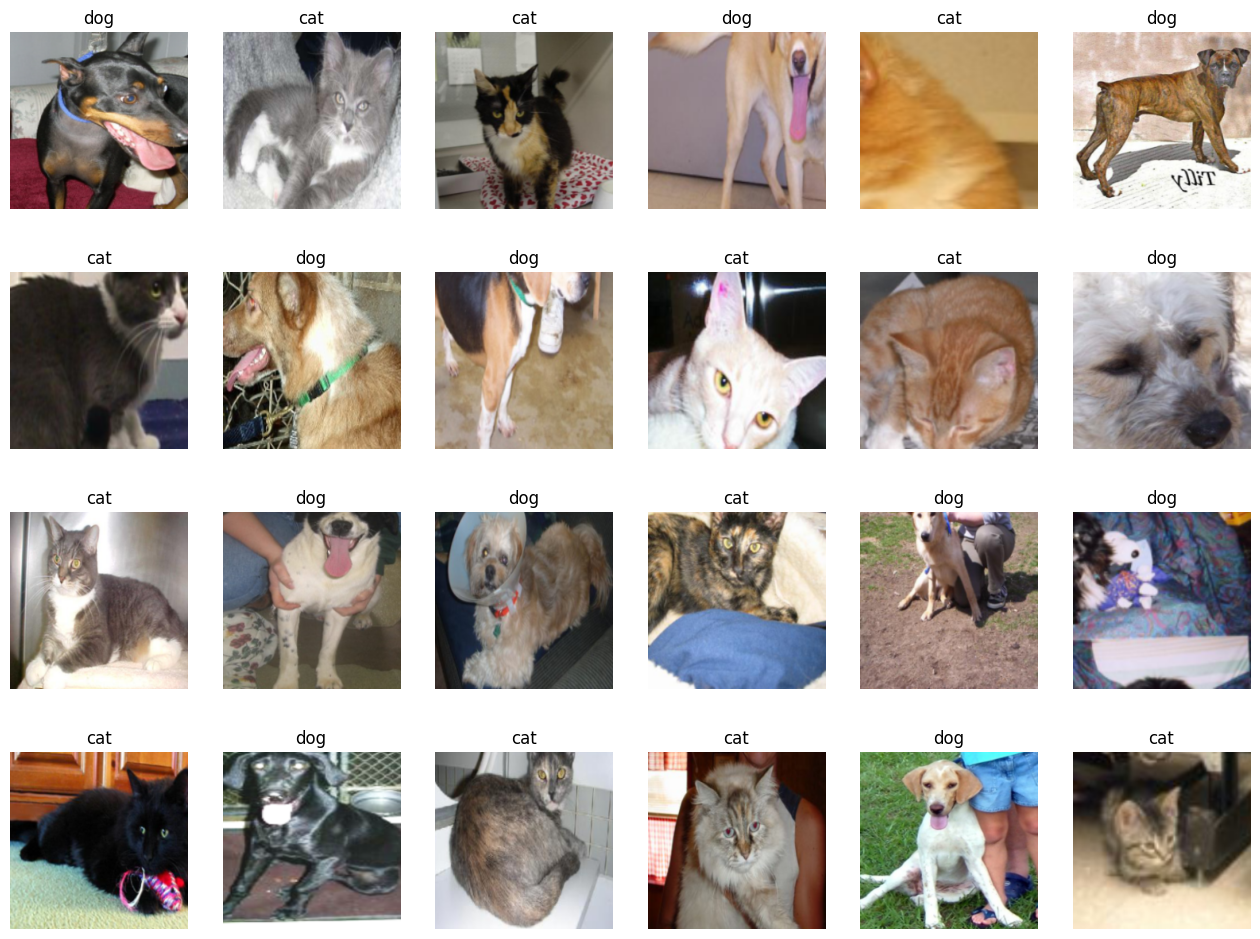

In [49]:
samples, labels = train_loader.__iter__().__next__()
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [50]:
resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(resnet18)

In [52]:
resnet18.fc = nn.Linear(512, 2)

In [53]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[-0.0261,  0.0133,  0.0295,  ...,  0.0273, -0.0075, -0.0377],
        [ 0.0424,  0.0388,  0.0060,  ...,  0.0298,  0.0189,  0.0327]])
fc.bias tensor([ 0.0058, -0.0407])


In [54]:
model = models.resnet18(pretrained = True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [55]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('../chap05/data/catanddog/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history

In [56]:
params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.7512 Acc: 0.5325

Epoch 1/12
----------
Loss: 0.4690 Acc: 0.7896

Epoch 2/12
----------
Loss: 0.3824 Acc: 0.8208

Epoch 3/12
----------
Loss: 0.2989 Acc: 0.9013

Epoch 4/12
----------
Loss: 0.2920 Acc: 0.9091

Epoch 5/12
----------
Loss: 0.2637 Acc: 0.9091

Epoch 6/12
----------
Loss: 0.2632 Acc: 0.8831

Epoch 7/12
----------
Loss: 0.2338 Acc: 0.9091

Epoch 8/12
----------
Loss: 0.2191 Acc: 0.9273

Epoch 9/12
----------
Loss: 0.2214 Acc: 0.8987

Epoch 10/12
----------
Loss: 0.2160 Acc: 0.9091

Epoch 11/12
----------
Loss: 0.2893 Acc: 0.8597

Epoch 12/12
----------
Loss: 0.2117 Acc: 0.9169

Training complete in 0m 53s
Best Acc: 0.927273


In [61]:
device

device(type='cuda')

In [58]:
test_path = '../chap05/data/catanddog/test'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


In [62]:
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('../chap05/data/catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history

In [63]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['../chap05/data/catanddog/00.pth', '../chap05/data/catanddog/01.pth', '../chap05/data/catanddog/02.pth', '../chap05/data/catanddog/03.pth', '../chap05/data/catanddog/04.pth', '../chap05/data/catanddog/05.pth', '../chap05/data/catanddog/06.pth', '../chap05/data/catanddog/07.pth', '../chap05/data/catanddog/08.pth', '../chap05/data/catanddog/09.pth', '../chap05/data/catanddog/10.pth', '../chap05/data/catanddog/11.pth', '../chap05/data/catanddog/12.pth']
Loading model ../chap05/data/catanddog/00.pth
Acc: 0.7551

Loading model ../chap05/data/catanddog/01.pth
Acc: 0.9490

Loading model ../chap05/data/catanddog/02.pth
Acc: 0.9490

Loading model ../chap05/data/catanddog/03.pth
Acc: 0.9694

Loading model ../chap05/data/catanddog/04.pth
Acc: 0.9592

Loading model ../chap05/data/catanddog/05.pth
Acc: 0.9592

Loading model ../chap05/data/catanddog/06.pth
Acc: 0.9184

Loading model ../chap05/data/catanddog/07.pth
Acc: 0.9490

Loading model ../chap05/data/catanddog/08.pth
Acc: 0.9388

L

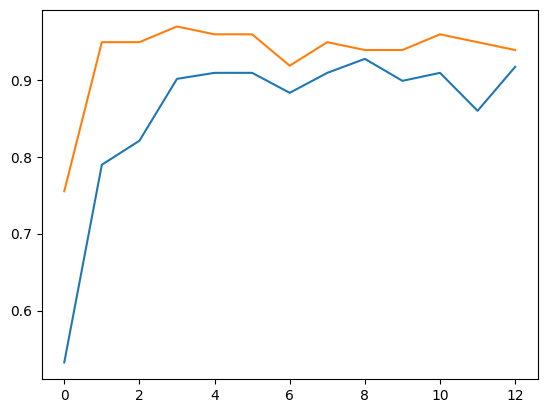

In [65]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

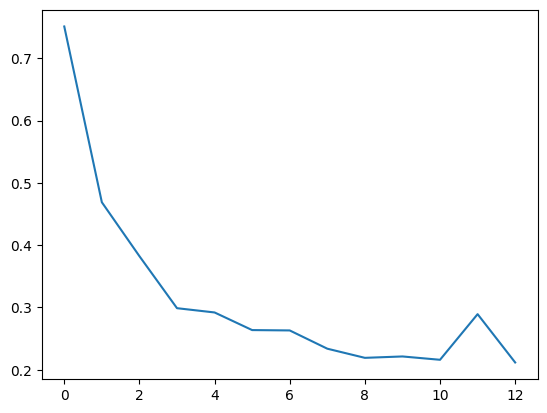

In [67]:
plt.plot(train_loss_hist)
plt.show()

In [70]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy() #detach 기울기에 영향 주지 x
  image = image.transpose(1,2,0)
  image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0,1)
  return image

In [72]:
exam = np.array([-1.8, -1.2, -0.7, 0.0, 0.8, 1.4, 1.9])
print(exam)
print(np.clip(exam, -0.5, 0.5)) #0.5 이상으로 범위 벗어나면 잘라버림

[-1.8 -1.2 -0.7  0.   0.8  1.4  1.9]
[-0.5 -0.5 -0.5  0.   0.5  0.5  0.5]


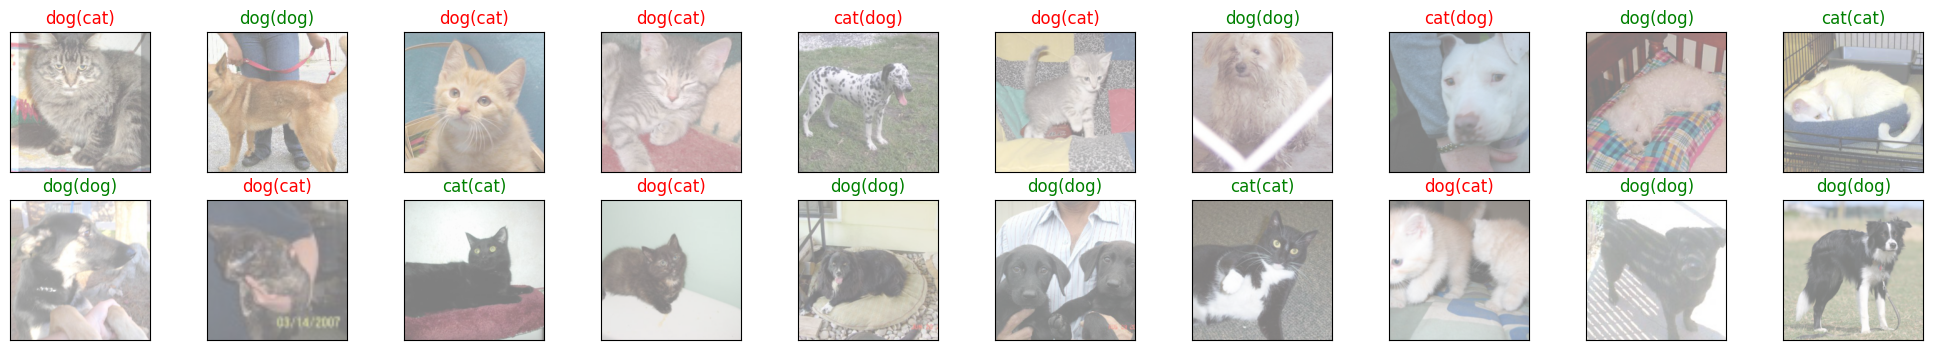

<Figure size 640x480 with 0 Axes>

In [75]:
classes = {0:'cat', 1:'dog'}

dataiter = iter(test_loader)
images, labels = dataiter.__next__()
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize = (25,4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks = [], yticks =[]) #2행 10열, tick 삭제(눈금)
  plt.imshow(im_convert(images[idx]))
  a.set_title(classes[labels[i].item()])
  ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color = ("green" if preds[idx] == labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom =  0.2, top = 0.6, hspace = 0)

- 데이터셋이 크고 pretrained 모델과 유사성이 작을 경우 -> 전체 재학습

- 데이터셋이 크고 pretrained 모델과 유사성이 클 경우 -> conv 뒷부분, fc layer 학습

- 데이터셋이 작고 pretrained 모델과 유사성이 작을 경우 -> conv 중간까지는 해줘야. 데이터가 적어서 이부분을 사용자가 어디까지 학습할 지 지정해야한다.

- 데이터셋이 작고 pretrained 모델과 유사성이 클 경우 -> 분류기만 학습


# Explainable CNN


In [43]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [44]:
%cd /content/drive/MyDrive/Colab Notebooks/Deeplearning_pytorch_Textbook/chap05

/content/drive/MyDrive/Colab Notebooks/Deeplearning_pytorch_Textbook/chap05


In [39]:
class XAI(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(128, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 512, bias=False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512), #여기서 부터 1dim
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512)
        x = self.classifier(x)
        return F.log_softmax(x)

In [40]:
model = XAI()
model.to(device)
model.eval()

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

In [41]:
class LayerActivations:
    features=[]
    def __init__(self, model, layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.features = output.detach().numpy()

    def remove(self):
        self.hook.remove()

In [32]:
#hook란?

x = torch.Tensor([0,1,2,3]).requires_grad_()
y = torch.Tensor([4,5,6,7]).requires_grad_()
w = torch.Tensor([0,1,2,3]).requires_grad_()
z = x+y #중간 계산 변수
o = w.matmul(z) #o 역시 중간 계산변수 <- 기울기 값을 저장하지 않음.
o.backward()
print(x.grad, y.grad, z.grad, w.grad, o.grad)

#hook을 이용하면 중간변수에 대한 기울기 값 역시 확인할 수 있다.

tensor([0., 1., 2., 3.]) tensor([0., 1., 2., 3.]) None tensor([ 4.,  6.,  8., 10.]) None


<ipython-input-32-e0d34248cf05>:9: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  print(x.grad, y.grad, z.grad, w.grad, o.grad)


torch.Size([1, 3, 100, 100])


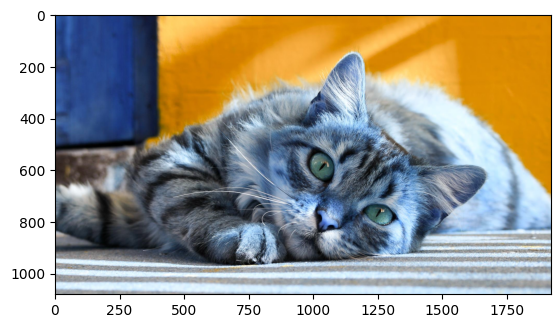

In [48]:
img = cv2.imread('./data/cat.jpg')
plt.imshow(img)
img = cv2.resize(img, (100,100), interpolation = cv2.INTER_LINEAR)
img = transforms.ToTensor()(img).unsqueeze(0) #dim = 0으로 설정해서 윗단계 차원 하나 더 생성됨
print(img.shape)

In [49]:
#unsqueeze에 대해

import torch
x1 = torch.rand(3,10,64)
x2 = x1.unsqueeze(dim=0)
print(x2.shape)
print('-'*10)
x3 = x1.unsqueeze(dim=1) #dim 1에 추가됨
print(x3.shape)
print('-'*10)
x4 = x1.unsqueeze(dim=2) #dim 2에 추가됨
print(x4.shape)

torch.Size([1, 3, 10, 64])
----------
torch.Size([3, 1, 10, 64])
----------
torch.Size([3, 10, 1, 64])


In [54]:
result = LayerActivations(model.features, 0) #가장 앞단의 conv layer 확인
img = img.to('cpu')
model.to('cpu')
model(img)
activations = result.features

<ipython-input-39-370f086c01ff>:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


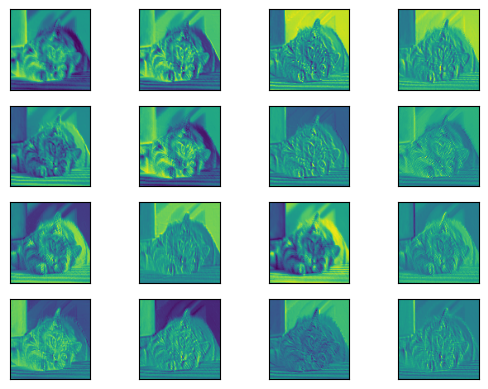

<Figure size 1200x800 with 0 Axes>

In [56]:
fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize = (12,8))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
for row in range(4):
  for column in range(4):
    axis = axes[row][column]
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])
    axis.imshow(activations[0][row*10+column])
plt.show() #이미지의 기본 정보가 아직 잘 유지됨. -> 앞단의 합성곱신경망이라.

In [59]:
result = LayerActivations(model.features, 20) #20th conv layer 확인
img = img.to('cpu')
model.to('cpu')
model(img)
activations = result.features

<ipython-input-39-370f086c01ff>:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


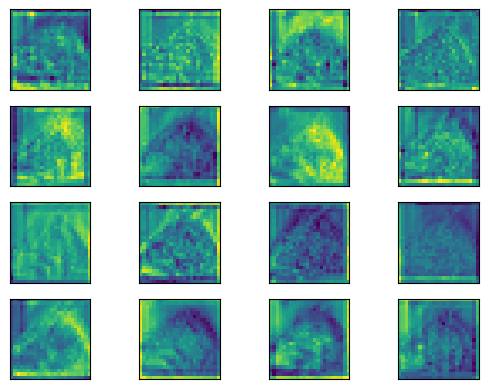

<Figure size 1200x800 with 0 Axes>

In [60]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [57]:
result = LayerActivations(model.features, 40) #40th conv layer 확인
img = img.to('cpu')
model.to('cpu')
model(img)
activations = result.features

<ipython-input-39-370f086c01ff>:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


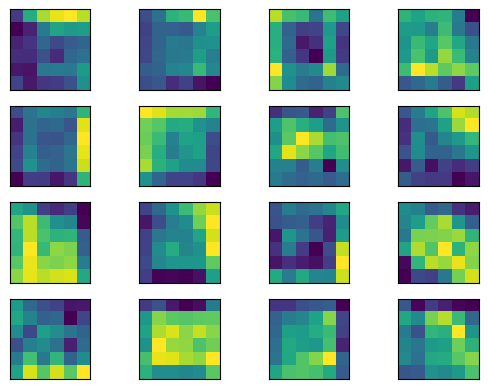

<Figure size 1200x800 with 0 Axes>

In [58]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

- 출력층으로 갈 수록 이미지의 추출된 features 들만 전달된다.

## Graph Convolutional network